In [57]:
%matplotlib inline

In [191]:
import os
import re
import json
import nltk
from nltk.book import FreqDist
from matplotlib import pyplot as plt
import countrynames
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np
import copy
from nltk.corpus import stopwords

## 读入原始数据

In [10]:
data_path = os.path.join('/home/chenzhongyu/notebooks/all-about-that-trump', 'json')
data_names = os.listdir(data_path)

In [163]:
data_dicts = []
for data_name in data_names:
    if data_name[0] != '.':
        with open(os.path.join(data_path, data_name), 'r') as f:
            dic = json.loads(''.join(f))
            data_dicts.append(dic)

In [164]:
len(data_dicts)

2600

In [23]:
data_dicts[0]

{'url': 'https://factba.se/transcript/donald-trump-interview-jonathan-karl-abc-news-october-31-2018',
 'title': 'Interview: Jonathan Karl of ABC News Interviews Donald Trump in Fort Myers, FL',
 'sentiment': 'Leans Negative',
 'emotions': ['Happy'],
 'keywords': ['people',
  'health care',
  'rough people',
  'young men',
  'close race'],
 'entities': ['Senate', 'United States', 'Mexico', 'Mexican army', 'ABC'],
 'people': ['Donald Trump (1,302 words)',
  'Jonathan Karl (298 words)',
  'Note (33 words)'],
 'transcript': [{'speaker': 'Note',
   'text': 'ABC released the transcript of the interview, but only released clips on broadcast, YouTube and Twitter. The video reassembles these clips based on the transcript. Where appropriate, gaps in the video are indicated.',
   'keywords': ['transcript', 'clips'],
   'entities': ['Twitter', 'YouTube', 'ABC'],
   'people': [],
   'sentiment': 'Neutral'},
  {'speaker': 'Jonathan Karl',
   'text': "Mr. President, we're six days away from the midte

## 预处理

In [168]:
new_data_dicts = []
for dic in data_dicts:
    try:
        year = int(dic['url'].split('-')[-1])
        if year >= 2015 and len(dic['transcript']) > 0:
            new_dic = copy.copy(dic)
            for i in range(len(new_dic['transcript'])):
                if new_dic['transcript'][i]['text'] is not None:
                    # 小写
                    text = new_dic['transcript'][i]['text'].lower()
                    # 去除[...]
                    split_list = re.split(r"\[([^\[\]]*)\]", text)
                    # tokenize
                    text_list = []
                    for t in split_list:
                        text_list += nltk.word_tokenize(t)
                    # 替换
                    new_dic['transcript'][i]['text'] = text_list
            new_data_dicts.append(new_dic)
    except Exception as e:
        print(e)
        print(dic['url'])
len(new_data_dicts)

invalid literal for int() with base 10: 'issues'
https://factba.se/transcript/donald-trump-position-paper-veterans-affairs-reform-key-issues
invalid literal for int() with base 10: 'MoCfIZQLrc8'
https://factba.se/transcript/donald-trump-vlog-unknown-MoCfIZQLrc8


2319

In [189]:
new_data_dicts[0]

{'url': 'https://factba.se/transcript/donald-trump-interview-jonathan-karl-abc-news-october-31-2018',
 'title': 'Interview: Jonathan Karl of ABC News Interviews Donald Trump in Fort Myers, FL',
 'sentiment': 'Leans Negative',
 'emotions': ['Happy'],
 'keywords': ['people',
  'health care',
  'rough people',
  'young men',
  'close race'],
 'entities': ['Senate', 'United States', 'Mexico', 'Mexican army', 'ABC'],
 'people': ['Donald Trump (1,302 words)',
  'Jonathan Karl (298 words)',
  'Note (33 words)'],
 'transcript': [{'speaker': 'Note',
   'text': ['abc',
    'released',
    'the',
    'transcript',
    'of',
    'the',
    'interview',
    ',',
    'but',
    'only',
    'released',
    'clips',
    'on',
    'broadcast',
    ',',
    'youtube',
    'and',
    'twitter',
    '.',
    'the',
    'video',
    'reassembles',
    'these',
    'clips',
    'based',
    'on',
    'the',
    'transcript',
    '.',
    'where',
    'appropriate',
    ',',
    'gaps',
    'in',
    'the',


In [76]:
types = []
for dic in new_data_dicts:
    l = dic['title'].split(':', 1)
    if len(l) != 2:
        print(dic['title'])
    types.append(l[0])
type_fdist = FreqDist(types)
type_fdist.most_common()

Remarks Donald Trump Addresses Generation Next Forum at The White House
Donald Trump Meets With Justin Trudeau of Canada
President Trump Gives Remarks to the National Convention of the American Legion
Remarks - Donald Trump Signs a Bill for Childhood Cancer Treatment
Press Conference - Donald Trump in Miami, Florida
Speech - Donald Trump in Wisconsin, Signing Buy American Executive Order 


[('Remarks', 964),
 ('Speech', 485),
 ('Interview', 335),
 ('Press Gaggle', 152),
 ('Press Conference', 78),
 ('Weekly Address', 61),
 ('Position Paper', 48),
 ('Donald Trump Vlog', 36),
 ('MSNBC', 32),
 ('Op-Ed', 25),
 ('Brief Remarks', 21),
 ('Prepared Remarks', 18),
 ('Debate', 14),
 ('Forum', 4),
 ('Deposition', 3),
 ('The New York Times', 3),
 ('The Washington Post', 3),
 ('Letter to the Editor', 2),
 ('Fox', 2),
 ('Letter', 2),
 ('ABC', 2),
 ('B-Roll', 2),
 ('Leaked Transcript', 2),
 ('Town Hall', 2),
 ('Press Statement', 1),
 ('Silence', 1),
 ('Remarks Donald Trump Addresses Generation Next Forum at The White House',
  1),
 ('Official Document', 1),
 ('Transcript', 1),
 ('Connecticut Post', 1),
 ('CBS', 1),
 ('Cal Thomas', 1),
 ('Recording', 1),
 ('Donald Trump Meets With Justin Trudeau of Canada', 1),
 ('Times of London and Bild', 1),
 ('President Trump Gives Remarks to the National Convention of the American Legion',
  1),
 ('Fox and Friends', 1),
 ('Mueller Report', 1),
 ('Re

## 相关的人

In [170]:
speaker_wordcnt = {}
for dic in new_data_dicts:
    for d in dic['transcript']:
        if d['speaker'] not in speaker_wordcnt:
            speaker_wordcnt[d['speaker']] = 0
        if d['text'] is not None:
            speaker_wordcnt[d['speaker']] += len(d['text'])
speaker_wordcnt_fdist = [(name, speaker_wordcnt[name]) for name in speaker_wordcnt]
speaker_wordcnt_fdist.sort(key= lambda k:k[1], reverse=True)
speaker_wordcnt_fdist

[('Donald Trump', 7563265),
 ('Question', 175417),
 ('Marco Rubio', 42459),
 ('Ted Cruz', 37434),
 ('Jason Forge', 36044),
 ('Sean Hannity', 35835),
 ('John Kasich', 31049),
 ('Ben Carson', 23589),
 ('Hillary Clinton', 23289),
 ('Jeb Bush', 21471),
 ('Mike Pence', 20914),
 ('Joe Scarborough', 20206),
 ('Chris Christie', 18257),
 ('Hugh Hewitt', 17300),
 ('Emmanuel Macron', 16629),
 ('Chris Wallace', 16241),
 ('Shinzo Abe', 13703),
 ('Jake Tapper', 13303),
 ('Unidentified', 12918),
 ('Maria Bartiromo', 11862),
 ('Chris Cuomo', 11329),
 ('Steve Bannon', 11192),
 ('Rand Paul', 10277),
 ('Ivanka Trump', 10114),
 ('Andrzej Duda', 10019),
 ('Brian Kilmeade', 9788),
 ('Anderson Cooper', 9704),
 ('Carly Fiorina', 9539),
 ('Note', 9500),
 ('Mika Brzezinski', 9131),
 ('Alex Azar', 8833),
 ('Kirstjen Nielsen', 8712),
 ('Moon Jae-in', 8398),
 ('Deborah Baum', 8391),
 ('Military Aide', 7646),
 ('Mike Huckabee', 7606),
 ('Vladimir Putin', 7494),
 ('Chuck Todd', 7219),
 ('Wolf Blitzer', 7196),
 ('Sco

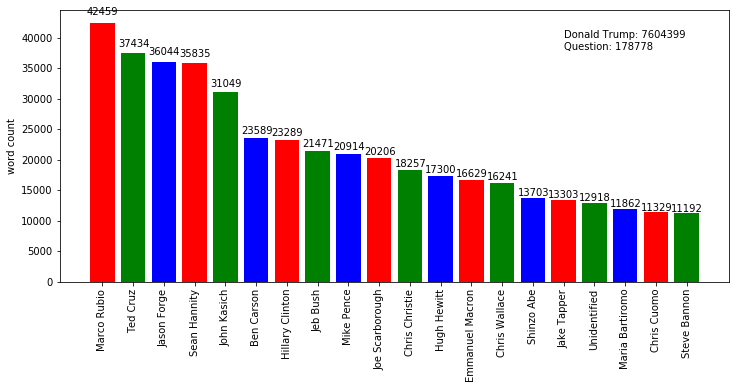

In [171]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.- 0.5, 1.03*height, '%s' % int(height))

plt.figure(figsize=(12,5))
name_list = [name for (name, cnt) in speaker_wordcnt_fdist[2:22]]
num_list = [cnt for (name, cnt) in speaker_wordcnt_fdist[2:22]]
autolabel(plt.bar(range(len(num_list)), num_list, color='rgb', tick_label=name_list))
plt.ylabel('word count')
plt.xticks(rotation=90)
plt.text(15, 40000, 'Donald Trump: 7604399')
plt.text(15, 38000, 'Question: 178778')
plt.show()

In [135]:

countrynames

<module 'countrynames' from '/home/chenzhongyu/anaconda3/envs/snn/lib/python3.6/site-packages/countrynames/__init__.py'>

In [194]:
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 'd',
 'did',
 'didn',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 'has',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 'it',
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 'more',
 'most',
 'mustn',
 'my',
 'myself',
 'needn',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 'she',
 'should',
 'shouldn',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 'the',
 'their',
 'theirs',
 'them',
 

In [199]:
word_cnt = []
for dic in new_data_dicts:
    for i, d in enumerate(dic['transcript']):
        if d['text'] is not None:
            for t in d['text']:
                if t not in stop_words:
                    word_cnt.append(t)
word_fdist = FreqDist(word_cnt)
word_fdist.most_common()

[('.', 616917),
 (',', 499424),
 ("'s", 121764),
 ('--', 83225),
 ("'re", 76683),
 ("n't", 66989),
 ('?', 62807),
 ('going', 54885),
 ('people', 48656),
 ('know', 47775),
 ('great', 30963),
 ('want', 29442),
 ('think', 29104),
 ("'ve", 28525),
 ('thank', 27602),
 ('said', 27052),
 ('like', 25365),
 ('right', 25098),
 ('one', 23515),
 ("'m", 23293),
 ('get', 22797),
 ('would', 22474),
 ('country', 21974),
 ('say', 21872),
 ('president', 19479),
 ("'ll", 18756),
 ('well', 18495),
 ('much', 18304),
 ('lot', 18249),
 ('good', 18147),
 ('really', 15905),
 ('many', 15422),
 ('go', 15290),
 ("''", 15150),
 ('``', 15001),
 ('time', 14711),
 ('see', 14407),
 ('us', 14404),
 ('look', 14289),
 ('got', 13802),
 ('years', 13638),
 ('back', 13425),
 ('applause', 13327),
 ('way', 13288),
 ('make', 12434),
 ('never', 12028),
 ('things', 10890),
 ('trump', 10794),
 ('take', 10639),
 ('big', 10197),
 ('tell', 10139),
 ('come', 10054),
 ('states', 9986),
 ('mean', 9952),
 ('let', 9931),
 ('even', 9851),


In [195]:
full_trump_text = ''
for dic in new_data_dicts:
    for d in dic['transcript']:
        if d['text'] is not None:
            for w in d['text']:
                if w not in stop_words:
                    full_trump_text += w + ' '
full_trump_text = full_trump_text[0:-1]
len(full_trump_text)

28034088

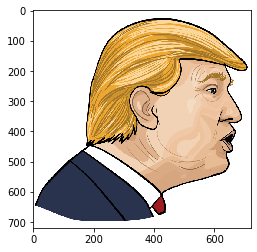

In [196]:
path_img = "trump.png"
background_image = np.array(Image.open(path_img))
wordcloud_fig = WordCloud(background_color="white", mask=background_image).generate(full_trump_text)
plt.imshow(background_image)

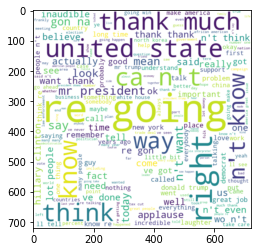

In [197]:
wordcloud_img = wordcloud_fig.to_image()
plt.imshow(wordcloud_img, interpolation="bilinear")

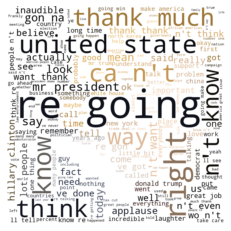

In [198]:
image_colors = ImageColorGenerator(background_image)
# 下面代码表示显示图片
plt.imshow(wordcloud_fig.recolor(color_func=image_colors), interpolation="bilinear")
# plt.imshow(wordcloud_fig, interpolation="bilinear")
plt.axis("off")
plt.show()

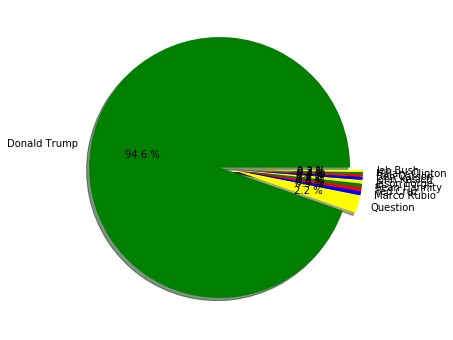

In [108]:
name_list = [name for (name, cnt) in speaker_wordcnt_fdist[:10]]
num_list = [cnt for (name, cnt) in speaker_wordcnt_fdist[:10]]
colors = ['green', 'yellow', 'blue', 'red']
# 圆形
plt.figure(1, figsize=(6, 6))
#决定分割部分，及其与其它部分之间的间距
expl = [0] * len(name_list)
expl[0] = 0.1
plt.pie(x=num_list, explode=expl, labels=name_list, autopct='%3.1f %%', colors=colors, shadow=True)
plt.show()

In [33]:
cnt = 0
error_cnt = 0
for dic in data_dicts:
    for i, d in enumerate(dic['transcript']):
        if d['speaker'] == 'Question':
            if i + 1 < len(dic['transcript']) and dic['transcript'][i + 1]['speaker'] == 'Donald Trump':
                cnt += 1
                if i + 2 < len(dic['transcript']) and dic['transcript'][i + 2]['speaker'] == 'Donald Trump':
                    error_cnt += 1
                    print(dic['transcript'][i: i + 3])
cnt, error_cnt

[{'speaker': 'Question', 'text': 'Yes, sir. Nobel.', 'keywords': ['sir'], 'entities': ['Nobel'], 'people': [], 'sentiment': 'Positive'}, {'speaker': 'Donald Trump', 'text': "I just think that President Moon was very nice when he suggested it. I want to get peace. It's the main thing. We want to get peace. That was a big problem, and I think it's going to work out well. We'll see. We're setting up meetings right now, and I think it's probably going to be announced over the next couple of days -- location and date.", 'keywords': ['President Moon', 'main thing', 'big problem'], 'entities': ['President'], 'people': [], 'sentiment': 'Positive'}, {'speaker': 'Donald Trump', 'text': 'But I thought it was very generous of President Moon of South Korea to make that statement, and I appreciate it. But the main thing is to get it done. I want to get it done. Thank you all. Thank you. Thank you very much.', 'keywords': ['President Moon', 'main thing'], 'entities': ['South Korea', 'President'], 'pe

[{'speaker': 'Question', 'text': 'Mr. President, tell us about your trip to New York, sir. What do you have planned tonight, sir?', 'keywords': ['Mr. President', 'trip', 'tonight'], 'entities': ['New York'], 'people': ['President'], 'sentiment': 'Neutral'}, {'speaker': 'Donald Trump', 'text': "Well, we're going to New York. We'll stay in New York tonight. We're going to go see the UFC fight. It's the championship fight. A lot of great people there. And it will be very interesting. I think you saw the numbers on the economy.", 'keywords': ['lot of great people', 'UFC fight'], 'entities': ['New York', 'UFC'], 'people': [], 'sentiment': 'Positive'}, {'speaker': 'Donald Trump', 'text': "It's one of the greatest economies we've ever had in the history of our country. Tremendous job numbers and tremendous numbers, generally. Our country is doing really well, military -- militarily. What we've done is incredible. We've built our military to a level that it's never seen before.", 'keywords': [

[{'speaker': 'Question', 'text': "It's an epidemic here in Ohio. My question is will you please, will you please cut off the source?", 'keywords': ['epidemic', 'question'], 'entities': ['Ohio'], 'people': [], 'sentiment': 'Negative'}, {'speaker': 'Donald Trump', 'text': 'Yeah, I will cut off the source. [Applause]', 'keywords': [], 'entities': ['source'], 'people': [], 'sentiment': 'Positive'}, {'speaker': 'Donald Trump', 'text': 'Build the wall. I will cut off the source. [Applause]', 'keywords': ['source'], 'entities': ['wall'], 'people': [], 'sentiment': 'Positive'}]
[{'speaker': 'Question', 'text': 'So will there be Fort Trump, sir?', 'keywords': ['Fort Trump', 'sir'], 'entities': [], 'people': [], 'sentiment': 'Neutral'}, {'speaker': 'Donald Trump', 'text': "So we're looking at doing things with Poland, including working with their military. And, as you know, Poland wants to build a great military facility for the United States. They'll build it. They're going to spend money. I me

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [156]:
s = 'for $20 [Billion].$40 [Billion]'
re.split(r"\[([^\[\]]*)\]", s)

['for $20 ', 'Billion', '.$40 ', 'Billion', '']

In [56]:
brackets = []
for dic in data_dicts:
    for i, d in enumerate(dic['transcript']):
        if d['text'] is not None:
            l = re.findall(r"\[([^\[\]]*)\]", d['text'])
        brackets += l
bracket_fdist = FreqDist(brackets)
bracket_fdist.most_common()
# 多数是指外界的情况，与文本内容无关。但是有少数是有关的，比如补上省略了的billion之类的词，但是毕竟比较少

[('Applause', 12453),
 ('Inaudible', 4779),
 ('Laughter', 4375),
 ('Via Interpreter', 1187),
 ('Crosstalk', 1136),
 ('Booing', 754),
 ('Audience Boos', 383),
 ('Laughs', 202),
 ('Via Translator', 177),
 ('inaudible', 149),
 ('applause', 144),
 ('Commercial Break', 142),
 ('Audience shouts "Boo"', 137),
 ('Cheering', 119),
 ('Audience yells "Boo"', 101),
 ('Applause, Laughter', 97),
 ('Applause and Cheering', 97),
 ('Audience cheering', 94),
 ('Applause, Cheering', 87),
 ('Bell Rings', 85),
 ('End Clip', 81),
 ('crosstalk', 78),
 ('Audience chants "USA"', 76),
 ('Laughter and applause', 68),
 ('Begin Video Clip', 64),
 ('Voiceover', 64),
 ('Audience chants USA', 62),
 ('End Video Clip', 61),
 ('Crowd cheering', 56),
 ('Audience chants "Trump"', 55),
 ('Mr. Itkowit', 49),
 ('Audience Chants USA', 44),
 ('Clip', 43),
 ('Break in Transcript', 39),
 ('End Video', 38),
 ('Off Microphone', 37),
 ('sic', 37),
 ('Audience calls out "Yeah"', 35),
 ('Audience yells "Yeah"', 33),
 ('Audio gap', 32

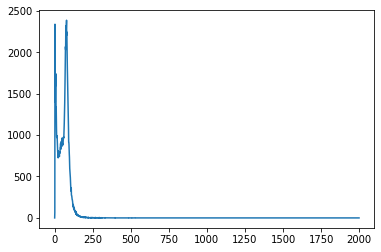

In [155]:
# 文本长度分布，基本上是短的文本段
cnt = [0] * 2000
for dic in new_data_dicts:
    for i, d in enumerate(dic['transcript']):
        if d['speaker'] == 'Donald Trump' and d['text'] is not None:
            cnt[len(d['text'])] += 1
plt.plot(cnt)

In [26]:
data_remarks = []
for dic in data_dicts:
    l = dic['title'].split(':', 1)
    if l[0] == 'Remarks':
        data_remarks.append(dic)
len(data_remarks)

971

In [27]:
data_remarks[0]

{'url': 'https://factba.se/transcript/donald-trump-remarks-cabinet-meeting-march-8-2018',
 'title': 'Remarks: Donald Trump Holds a Cabinet Meeting at The White House',
 'sentiment': 'Leans Positive',
 'emotions': ['Happy'],
 'keywords': ['long time', 'country', 'steel', 'people', 'national security'],
 'entities': ['China', 'NAFTA', 'United States', 'president', 'Mexico'],
 'people': ['Donald Trump (3,284 words)',
  'Question (18 words)',
  'Unidentified (6 words)',
  'Gary Cohn (1 word)'],
 'transcript': [{'speaker': 'Donald Trump',
   'text': "OK, thank you very much. It's going to be a very busy day. We have a lot of things in store. You know, we're going to be meeting today with the video makers having to do with the violence and what impact and effect that has on school shootings and on children. And we have a very big meeting at 3:30. I'd call it an economic meeting, something we have to do to protect our steel, our aluminum in our country.",
   'keywords': ['OK', 'school shootin

In [28]:
def dict2text(dic):
    text = ''
    for d in dic['transcript']:
        if d['speaker'] == 'Donald Trump':
            text += d['text']
    return text

In [29]:
dict2text(data_remarks[0])

"OK, thank you very much. It's going to be a very busy day. We have a lot of things in store. You know, we're going to be meeting today with the video makers having to do with the violence and what impact and effect that has on school shootings and on children. And we have a very big meeting at 3:30. I'd call it an economic meeting, something we have to do to protect our steel, our aluminum in our country.But I want to just say that this one cabinet meeting has a lot of things to -- a lot of things have been happening. Very positive things have been happening for our country.I'm pleased to report that our very massive tax cuts are continuing to show tremendous results. Ninety percent of American workers are already seeing bigger paychecks, and that number's actually going to go up.Almost 4.6 million people have received tax-cut bonuses. Wages are rising at the fastest pace in more than a decade, something that people have been waiting for, as you know.When I was campaigning, I was talk